## On nested cross validation

#### This notebook builds a function to help handle nested cross validation using prostate cancer data from The Elements of Statistical Learning.

#### Notes on Nested CV. 
#### Personally I have always found this confusing so this notebook is going to be used to help flesh out the idea behind it. From my research I can gather:
##### (1) Cross validation can be used to evaluate models and tune parameters, e.g. https://github.com/mspil88/data_science_and_stats/blob/main/ESL_One_Standard_Error_Models2.ipynb
##### (2) Nested CV purports to allow us to do both with two loops, an outer loop to evaluate the algorithm and an inner to handle the hyperparameter optimisation
##### (3) This post provides an excellent description https://stats.stackexchange.com/a/65156. Specifically "Treat the inner cross validation as part of the model fitting procedure. That means that the fitting including the fitting of the hyper-parameters (this is where the inner cross validation hides) is just like any other model esitmation routine.The outer cross validation estimates the performance of this model fitting approach. For that you use the usual assumptions"



In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [3]:
def data_proc():
    '''Returns training and test sets as well as a list containing feature names'''
    
    cols = pd.read_csv(r"..\nested_cross_validation_wip\prostate.csv", nrows=0)
    data = pd.read_csv(r"..\nested_cross_validation_wip\prostate.csv", usecols = [i for i in cols if i != 'id'])
    
    target = 'lpsa'
    features = ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']
    
    X, y = data[features].values, data[target].values
    train_idx = data.train=="T"
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[~train_idx], y[~train_idx]
    
    
    
    return X_train, y_train, X_test, y_test, features

def standardiser(X_train, X_test):
    '''Returns a standardised matrix for given inputs X_train, X_test 
    ensuring the mean and sd from the training set are used'''
    mu_train = np.mean(X_train, axis=0)
    sd_train = np.std(X_train, axis=0)
    return (X_train-mu_train)/sd_train, (X_test-mu_train)/sd_train

def std_scaler(X_train, X_test):
    '''Same as above but using Sklearn to sort this'''
    std_scale = StandardScaler().fit(X_train)
    return std_scale.transform(X_train), std_scale.transform(X_test)


In [4]:
X_train, y_train, X_test, y_test, features = data_proc()

In [5]:
X_train, X_test = standardiser(X_train, X_test)

### Trial run on a ridge model

In [6]:
params = {'alpha':[436, 157, 78, 44, 24, 12, 4, 0.00001]}


In [7]:
def nestedCV(X, y, model, params, outer_splits=5, inner_splits=5, gs_score = 'neg_mean_squared_error', random_seed=0):
    '''Perform nested cross validation returning the best hyperparameters from the inner loop and error from the outer loop
        NB: This is a WIP and needs a lot of checking
    '''
    
    outer_cv = KFold(n_splits=outer_splits, random_state=random_seed, shuffle=True)
    
    train_error = []
    val_error = []
    train_val_diff = []
    
    train_sd = []
    val_sd = []
    
    inner_cv = KFold(n_splits=inner_splits, random_state=random_seed, shuffle=True)
    
    best_params = []
    
    for train_outer_idx, val_outer_idx in outer_cv.split(X,y):
        X_train, X_val = X[train_outer_idx,:], X[val_outer_idx,:]
        y_train, y_val = y[train_outer_idx], y[val_outer_idx]
        
        clf = GridSearchCV(estimator = model, param_grid = params, scoring=gs_score,
                           return_train_score = True).fit(X_train, y_train)
        
        mean_train_score = clf.cv_results_['mean_train_score']
        sd_train_score = clf.cv_results_['std_train_score']
        mean_val_score = clf.cv_results_['mean_test_score']
        sd_val_score = clf.cv_results_['std_test_score']
        best_params = clf.best_params_
        
        train_error.append(-1*mean_train_score[np.where(mean_val_score == clf.best_score_)[0][0]])
        val_error.append(-1*clf.best_score_)
        train_val_diff.append(mean_train_score[np.where(mean_val_score == clf.best_score_)[0][0]] - clf.best_score_)
        
    
    return {'best_param': best_params,
           'train_error': train_error,
           'val_error': val_error,
           'train_val_diff': train_val_diff,
           }

In [8]:
output = nestedCV(X_train, y_train, Ridge(), params, inner_splits=10, outer_splits=10)

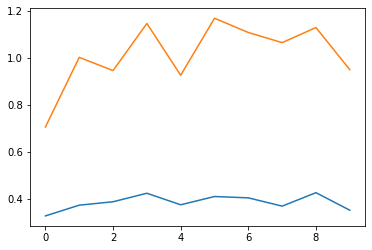

In [9]:
plt.plot([i for i in range(10)] ,output['train_error'])
plt.plot([i for i in range(10)] ,output['val_error'])


In [10]:
output['best_param']

{'alpha': 1e-05}